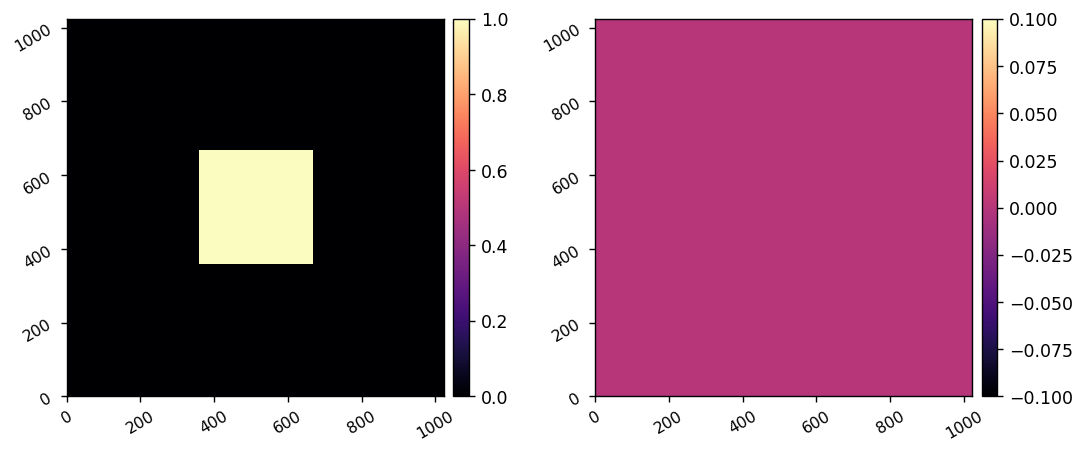

In [3]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

from roman_cgi_iefc_2.poppy_roman_cgi_phasec import cgi
from roman_cgi_iefc_2 import iefc_utils as iefcu
from roman_cgi_iefc_2 import iefc_sim as iefc

import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = 2*fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = 2*fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = 2*fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = 2*fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

def reset(quiet=False):
    reload(iefcu)
    reload(iefc)
    reload(cgi)
    hlci = cgi.CGI_POPPY(polaxis=0, use_opds=True, use_fieldstop=False, quiet=quiet, ngpus=1/4)
    hlci.set_dm1(dm1_flatmap)
    hlci.set_dm2(dm2_flatmap)
#     hlci.set_dm1(dm1_design)
#     hlci.set_dm2(dm2_design)
    return hlci

hlci = reset()
misc.myimshow2(hlci.inwave.intensity.get(), hlci.inwave.phase.get())

npsf = hlci.npsf
Nact = hlci.Nact

(calc_psf pid=47269) Propagating wavelength 575.000 nm.
All PSFs calculated in 0.898s
(calc_psf pid=47269) PSF calculated in 0.84s


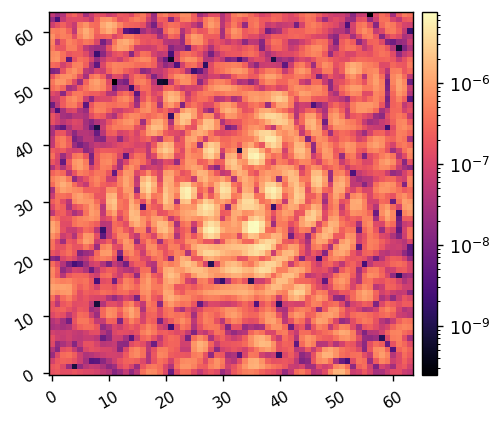

In [4]:
hlci = reset()
ref_psf = hlci.calc_psfs()[0][-1]
misc.myimshow(ref_psf.intensity.get(), lognorm=True)

# Create dark hole ROI to calibrate and control

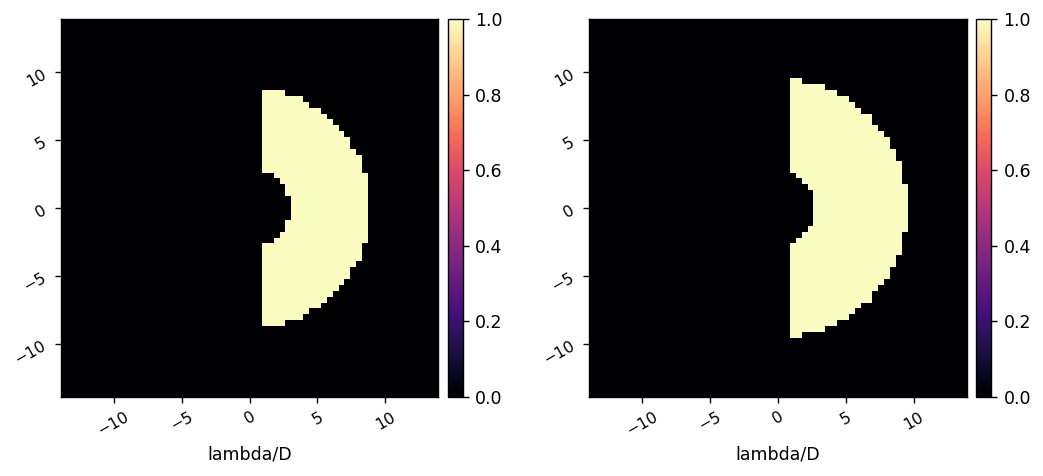

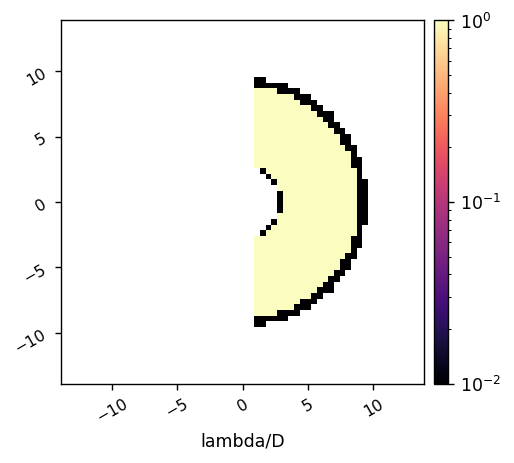

In [5]:
hlci = reset()
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 9

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x'
}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.2,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
    'direction' : '+x'
}
control_mask = iefcu.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=hlci.psf_pixelscale_lamD, pxscl2=hlci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=hlci.psf_pixelscale_lamD)


# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
Calibration modes required: 296


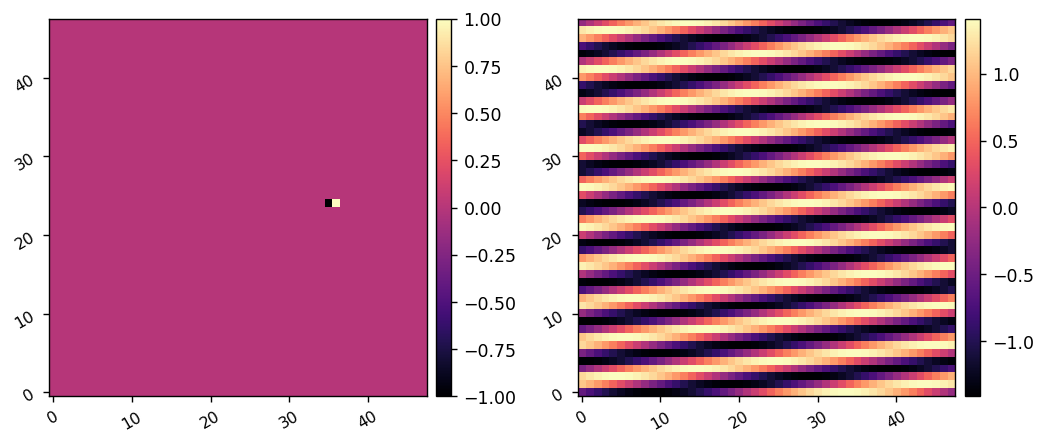

(True, True)

In [6]:
hlci = reset()

probe_modes = iefcu.create_probe_poke_modes(Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)
calibration_modes, fx, fy = iefcu.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)

calibration_amplitude = 0.006 * hlci.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * hlci.wavelength_c.to(u.m).value
nmodes = calibration_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))
misc.myimshow2((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)), calibration_modes[0].reshape(Nact,Nact))

isinstance(probe_modes, np.ndarray), isinstance(calibration_modes, np.ndarray)

# Calibrate IEFC (or load in previous calibration data)

In [139]:
fname = 'dshaped_Yopds_polaxis{:d}_iwa{:.1f}_owa{:.1f}'.format(hlci.polaxis, 
                                                           dh_params['inner_radius'], dh_params['outer_radius'])
print(fname)

dshaped_Yopds_polaxis0_iwa3.0_owa6.0


In [140]:
hlci = reset(quiet=True)

response_cube, calibration_cube = iefc.calibrate(hlci, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, DM=1, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 92 in 1.940s
	Calibrated mode 2 / 92 in 3.831s
	Calibrated mode 3 / 92 in 5.726s
	Calibrated mode 4 / 92 in 7.626s
	Calibrated mode 5 / 92 in 9.517s
	Calibrated mode 6 / 92 in 11.421s
	Calibrated mode 7 / 92 in 13.327s
	Calibrated mode 8 / 92 in 15.232s
	Calibrated mode 9 / 92 in 17.150s
	Calibrated mode 10 / 92 in 19.068s
	Calibrated mode 11 / 92 in 20.987s
	Calibrated mode 12 / 92 in 22.901s
	Calibrated mode 13 / 92 in 24.809s
	Calibrated mode 14 / 92 in 26.714s
	Calibrated mode 15 / 92 in 28.630s
	Calibrated mode 16 / 92 in 30.547s
	Calibrated mode 17 / 92 in 32.477s
	Calibrated mode 18 / 92 in 34.393s
	Calibrated mode 19 / 92 in 36.333s
	Calibrated mode 20 / 92 in 38.263s
	Calibrated mode 21 / 92 in 40.192s
	Calibrated mode 22 / 92 in 42.116s
	Calibrated mode 23 / 92 in 44.039s
	Calibrated mode 24 / 92 in 45.967s
	Calibrated mode 25 / 92 in 47.890s
	Calibrated mode 26 / 92 in 49.817s
	Calibrated mode 27 / 92 in 51.733s
	Calibrated mode 28 /

In [142]:
iefcu.save_pickle(data_dir/'response-data'/fname, response_cube)
iefcu.save_pickle(data_dir/'calibration-data'/fname, calibration_cube)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/dshaped_Yopds_polaxis0_iwa3.0_owa6.0


In [143]:
response_cube = iefcu.load_pickle(data_dir/'response-data'/fname)
calibration_cube = iefcu.load_pickle(data_dir/'calibration-data'/fname)

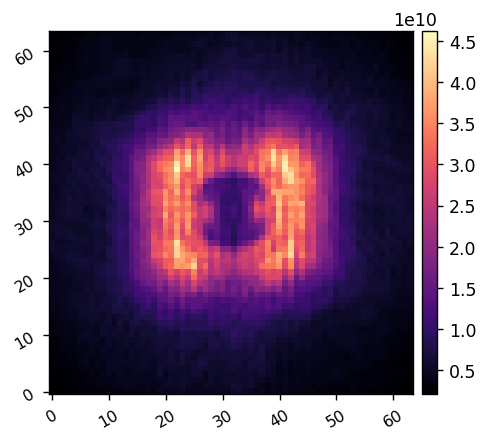

In [144]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64).get())

# Create control matrix

In [145]:
hlci = reset()

# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix = iefc.construct_control_matrix(response_cube, cp.array(weights.flatten()), rcond=1e-2, pca_modes=None)

# Run IEFC

In [150]:
hlci = reset(quiet=True)

images, dm_commands = iefc.run(hlci, control_matrix, probe_modes, probe_amplitude, 
                               calibration_modes, cp.array(weights), 
                               num_iterations=15, gain=-0.5, leakage=0.0,
                               display=False)

Running I-EFC...
	Closed-loop iteration 1 / 15
	Closed-loop iteration 2 / 15
	Closed-loop iteration 3 / 15
	Closed-loop iteration 4 / 15
	Closed-loop iteration 5 / 15
	Closed-loop iteration 6 / 15
	Closed-loop iteration 7 / 15
	Closed-loop iteration 8 / 15
	Closed-loop iteration 9 / 15
	Closed-loop iteration 10 / 15
	Closed-loop iteration 11 / 15
	Closed-loop iteration 12 / 15
	Closed-loop iteration 13 / 15
	Closed-loop iteration 14 / 15
	Closed-loop iteration 15 / 15
I-EFC loop completed


In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0


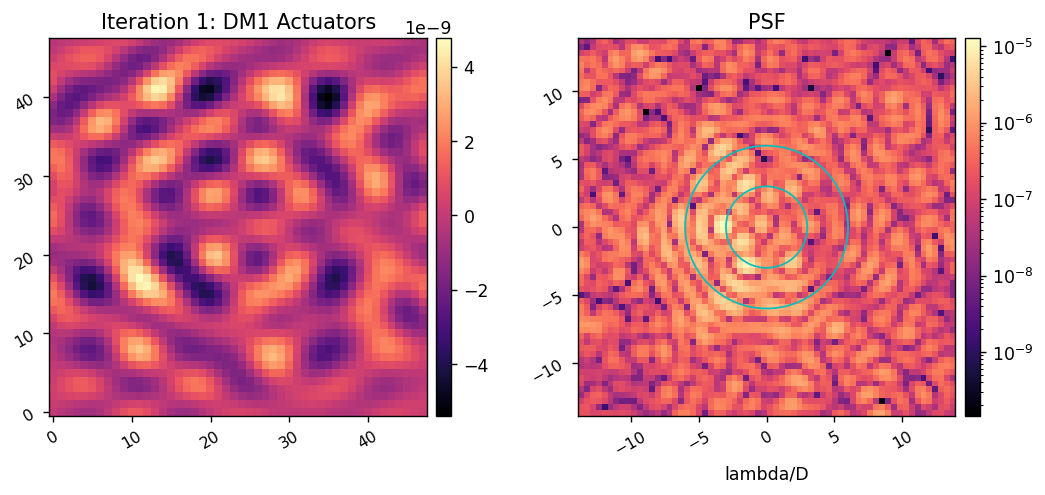

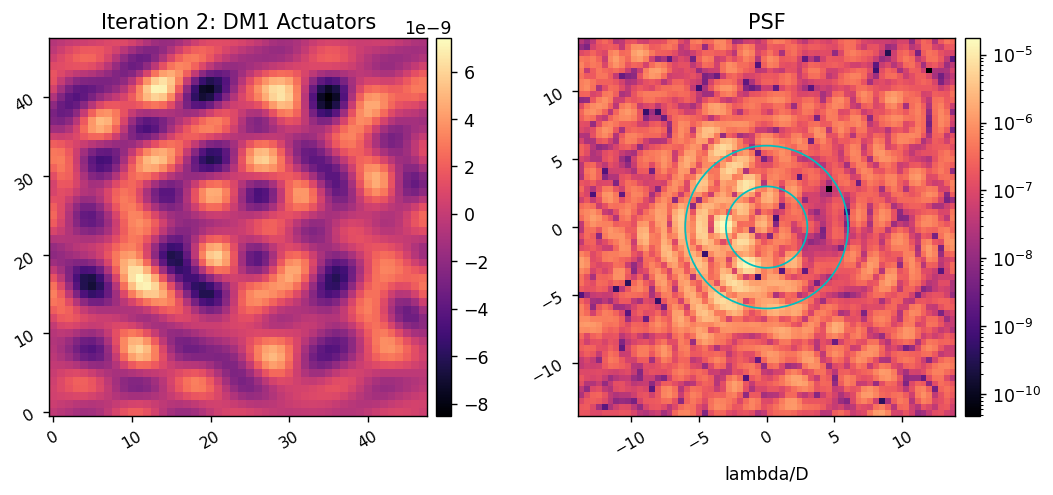

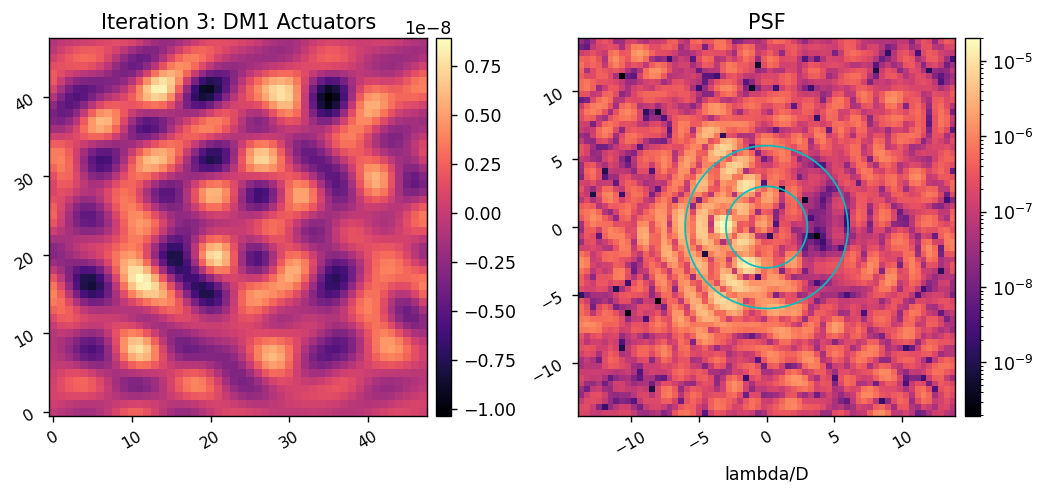

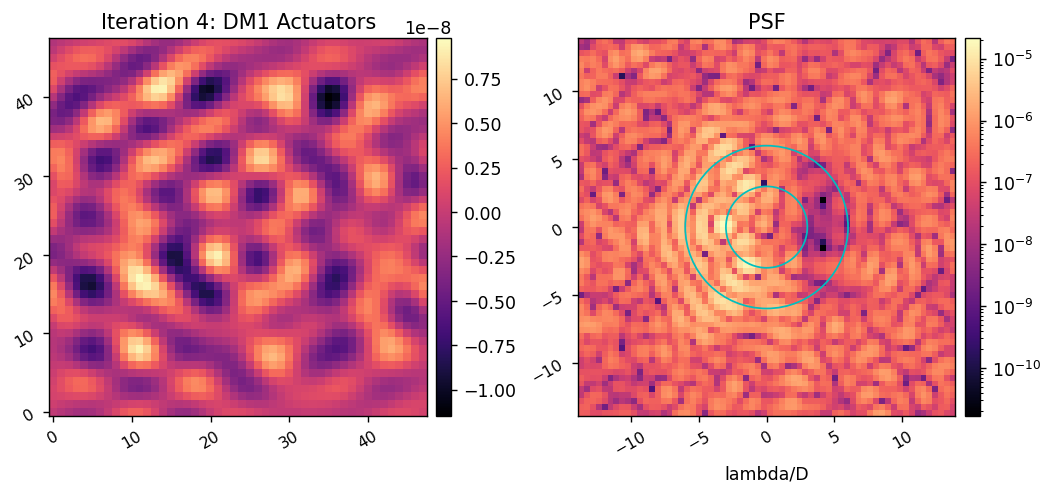

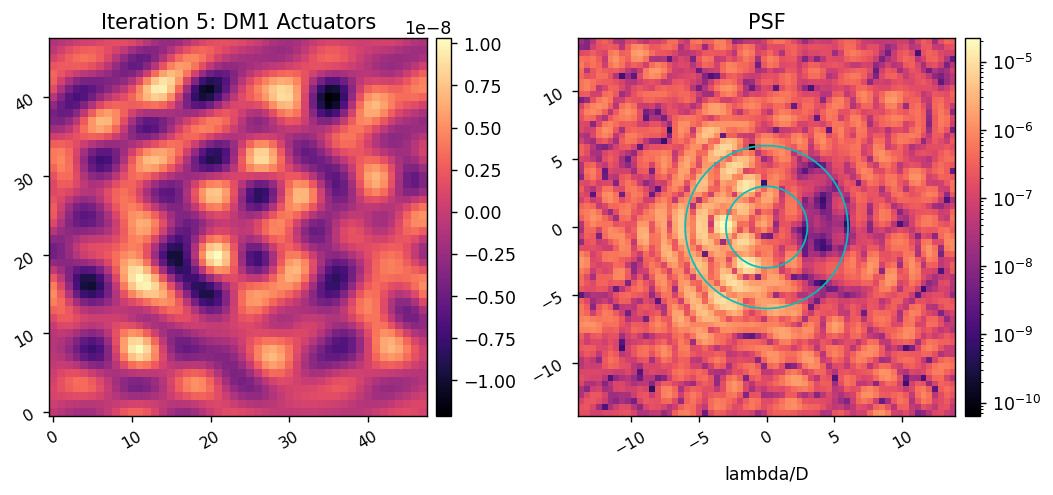

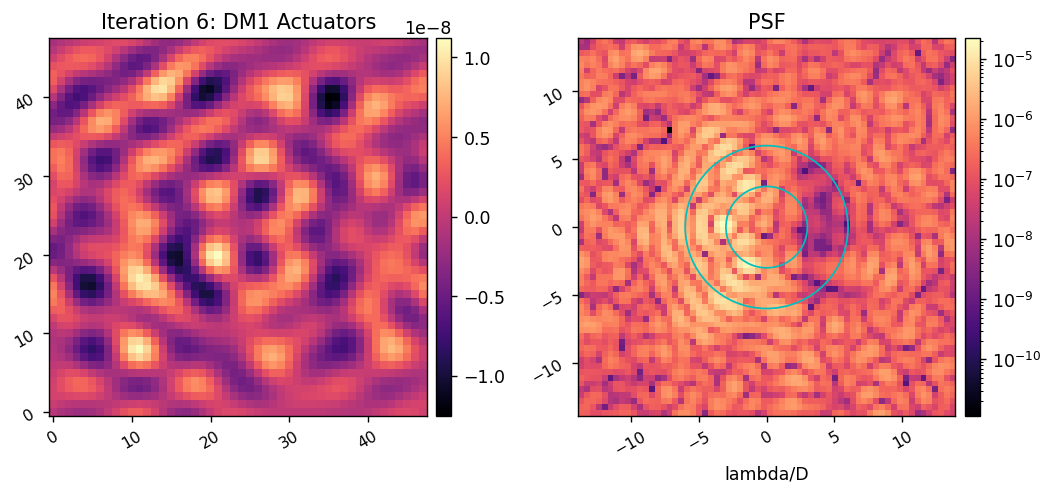

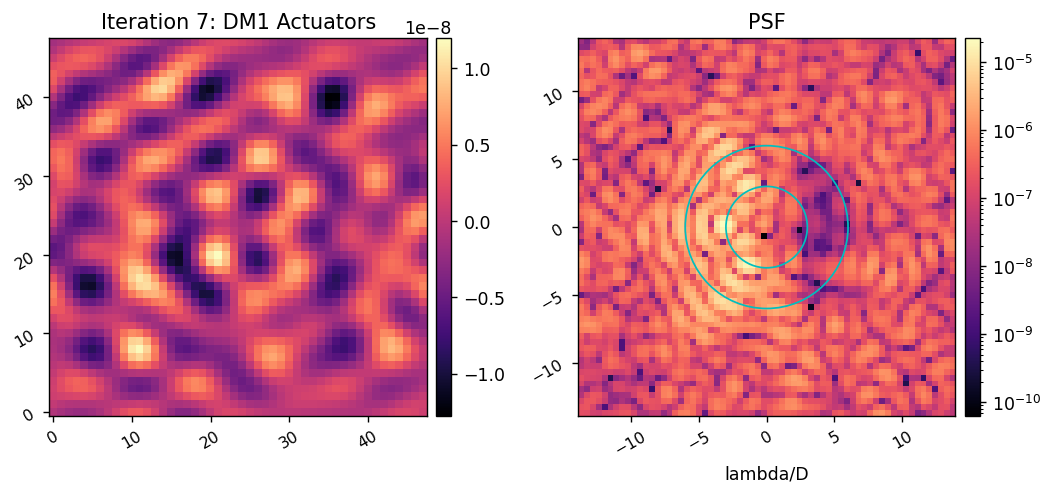

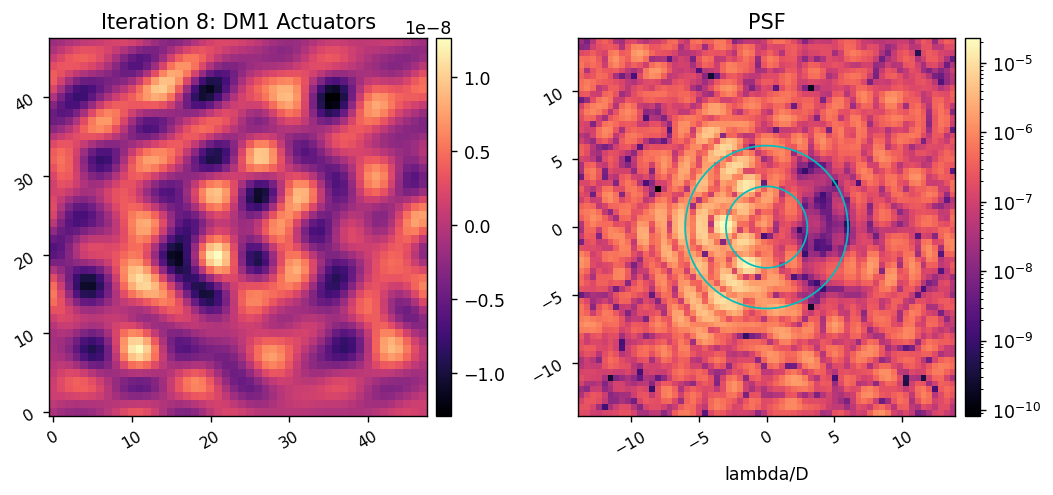

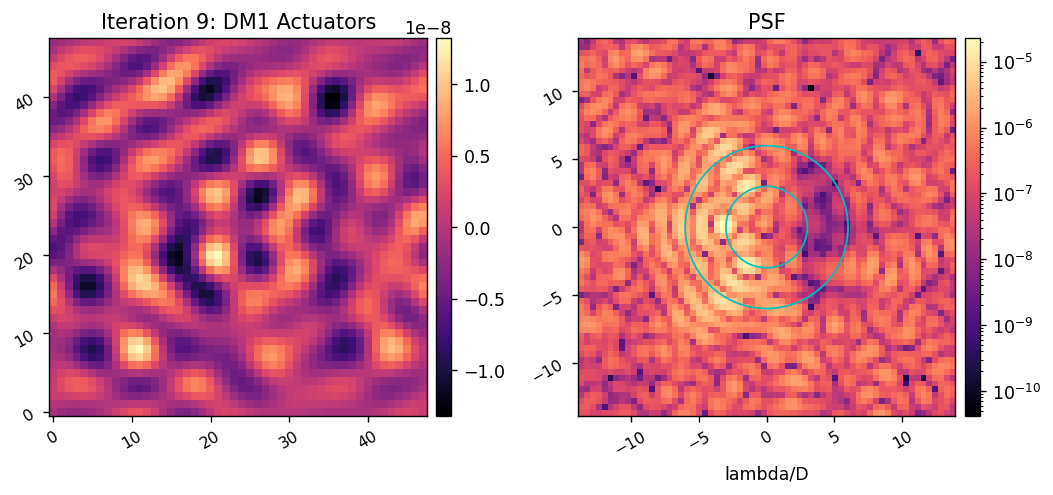

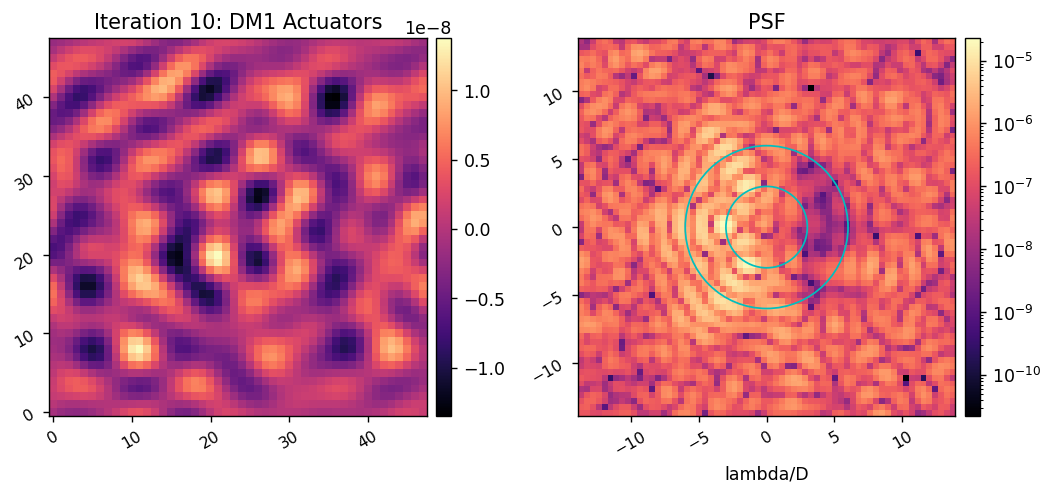

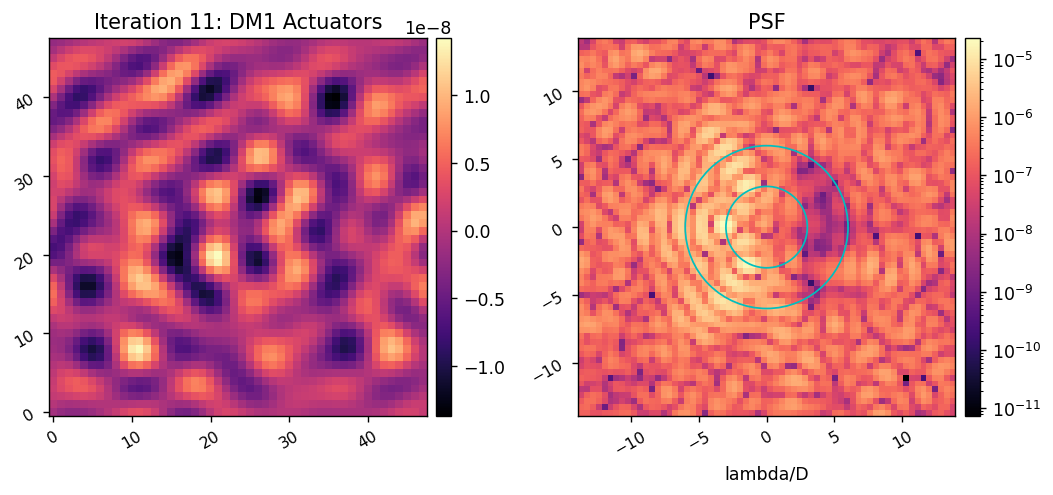

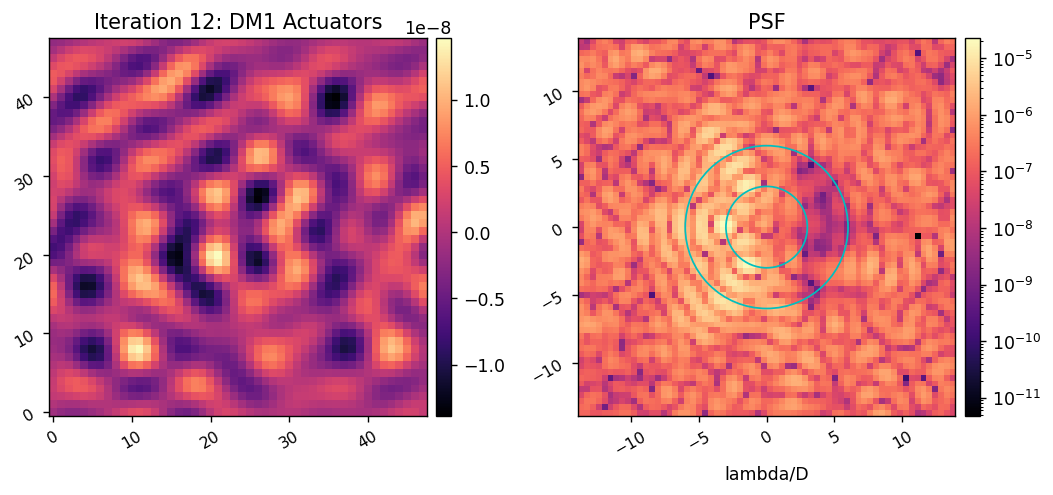

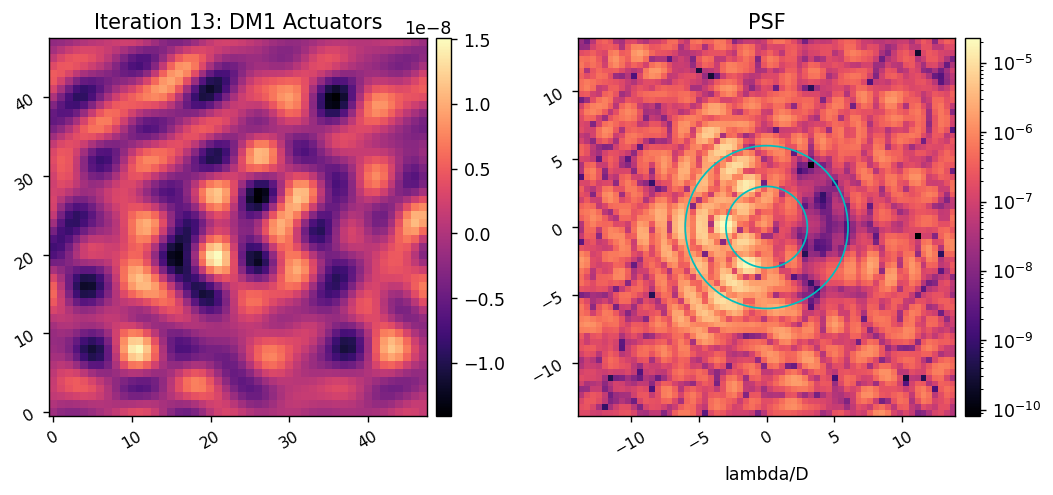

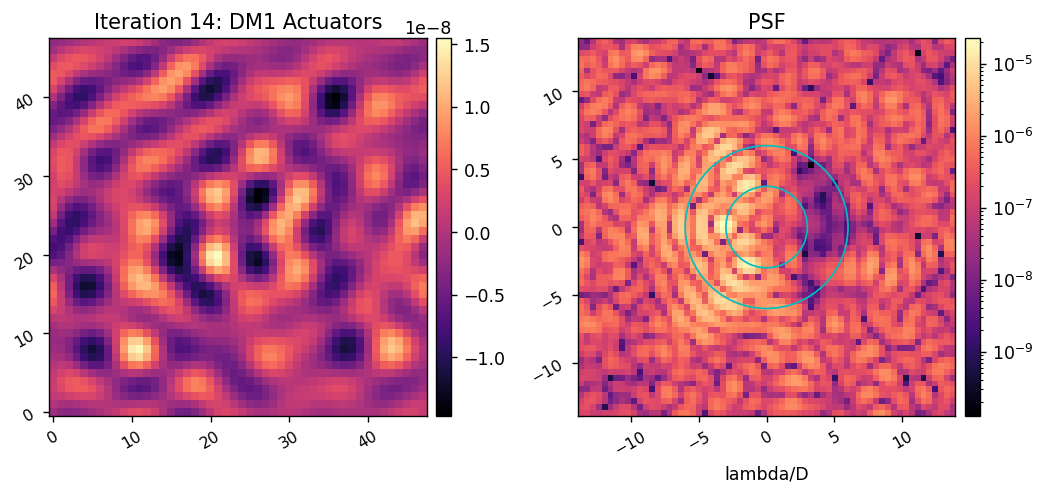

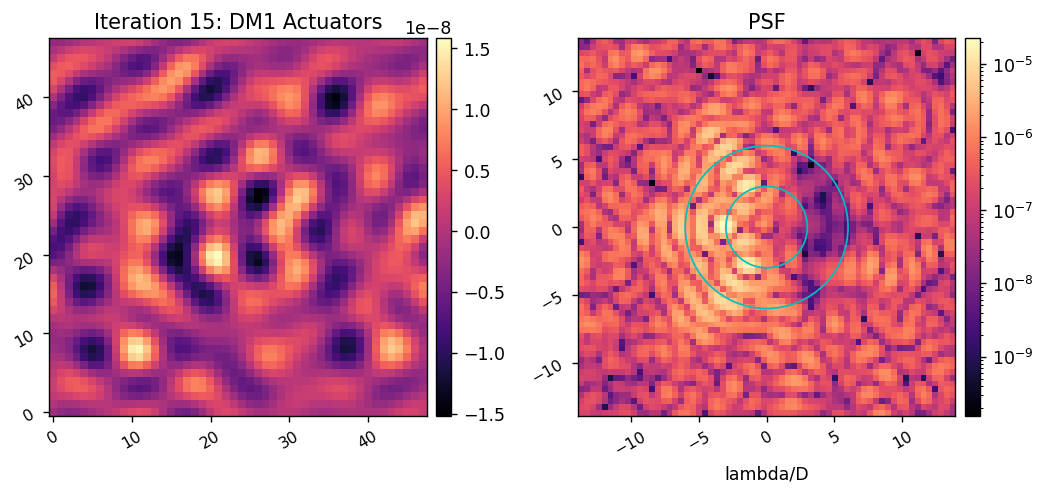

In [151]:
for i in range(len(images)):
    patches = iefcu.create_circ_patches(dh_params)
    misc.myimshow2(dm_commands[i], images[i].intensity.get(), 
                   'Iteration {:d}: DM1 Actuators'.format(i+1), 'PSF',
                   lognorm2=True, pxscl2=hlci.psf_pixelscale_lamD, patches2=patches)